<a href="https://colab.research.google.com/github/danpele/Introduction-to-XAI/blob/main/2.%20Global%20%20Explanation%20Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Explanation Methods
We start by creating the XGBoost-based credit risk model. XGBoost models are powerful but can be complex and difficult to interpret, making them an excellent example of a non-explainable model that we can diagnose and eventually interpret using the explanation methods discussed in the session.

The outline of today's session is as follows:

 - Create black-box XGBoost classifier
 - Explain the black-box using a linear regression surrogate model
 - Compute permutation-based feature importance
 - Examine partial dependence

In [10]:
# Standard libraries for data data handling and plotting
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

Below, we provide the code which you can run to load our credit data, train an XGBoost classifier, and produce test set predictions.

Accuracy: 0.93


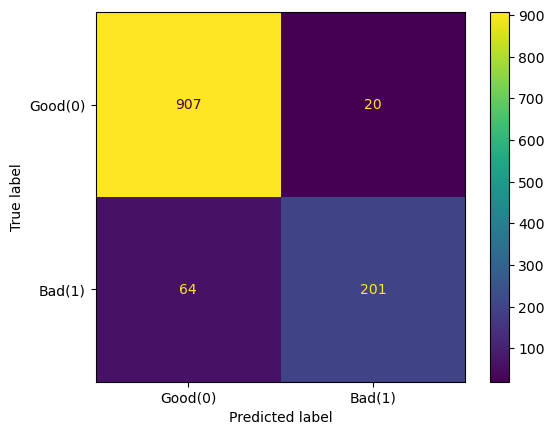

In [11]:


# 1. Load data from GitHub
data_url = "https://raw.githubusercontent.com/stefanlessmann/ASE-ML/master/hmeq.csv"
df = pd.read_csv(data_url)

# 2. Perform some minimal preprocessing to facilitate training a NN
df = df.drop(columns=["REASON", "JOB"], axis=1)  # delete categorical features
y = df.pop("BAD")  # Remove the target variable so that it remains unchanged
df = df.fillna(value=df.mean())  # Mean-impute missing values
scaler = MinMaxScaler(feature_range=(0,1))  # Scale feature values
X = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 3. Partition data into training (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGB
import xgboost as xgb
from sklearn.metrics import accuracy_score
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate the model

yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f"Accuracy: {accuracy:.2f}")


# Compute a performance indicator over the test set predictions. 

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=yhat, labels=[0, 1], display_labels=['Good(0)', 'Bad(1)']);


## Surrogate model-based explanation
A surrogate model is, by definition, an intrinsically interpretable model, which we train to predict (aka reproduce) the predictions of a black-box model.

We just created a black-box model above. As surrogate model, we will use linear regression, and see how well we can linearly approximate our XGB. Specifically, fit the surrogate model to the predicted class *probabilities* of the neural network using the original features. To predict probabilities, you will need to use the method `predict_proba()`, which any `sklearn` classifier provides.

One question worth discussing in this context is which data set to use for fitting the surrogate model, the training or test data. From a programming perspective, it does not make a difference. So first develop your code and then we discuss the subtle differences between the two options.

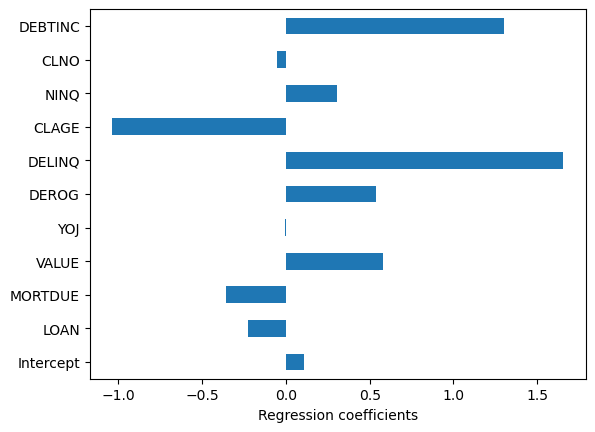

In [12]:
# Linear regression as surrogate model
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# Produce (probability) forecasts for the test data
yhat_prob = model.predict_proba(X_test)[:, 1]

# Fit a linear regression model on the original features using the probability forecasts
lreg = LinearRegression()
lreg.fit(X_test, yhat_prob)

# Create a DataFrame to hold the intercept and coefficients
explanation = pd.concat([
    pd.DataFrame([lreg.intercept_], index=["Intercept"]),
    pd.DataFrame(lreg.coef_, index=X_test.columns)
], axis=0)

# Plot the regression coefficients
explanation.plot.barh(legend=False)
plt.xlabel("Regression coefficients")
plt.savefig('surrogate_model.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()





### Interpretation of the Surrogate Model Results:

The surrogate model plot you provided shows the coefficients of a linear regression model fitted to the probability forecasts from an XGBoost classifier. Each bar represents the magnitude and direction of the impact that each feature has on the predicted probability. Positive coefficients indicate a positive influence on the probability, while negative coefficients indicate a negative influence.

Let's interpret the coefficients:

1. **DEBTINC**: This feature has a large positive coefficient, suggesting that as the debt-to-income ratio increases, the probability of the target variable (`BAD`) being positive increases.

2. **CLNO**: The number of credit lines has a moderate positive impact on the probability.

3. **DEROG**: The number of derogatory reports has a moderate positive impact on the probability, indicating that more derogatory marks increase the likelihood of the target variable being positive.

4. **CLAGE**: The age of the oldest credit line has a large negative impact on the probability, indicating that older credit lines are associated with a lower probability of the target variable being positive.

5. **DELINQ**: The number of delinquent credit lines has a large positive impact on the probability, suggesting that more delinquencies significantly increase the likelihood of the target variable being positive.

6. **YOJ**: Years at the current job has a very small positive impact on the probability.

7. **VALUE**: The value of the property has a small positive impact on the probability.

8. **MORTDUE**: The amount due on the mortgage has a small negative impact on the probability.

9. **LOAN**: The loan amount has a small negative impact on the probability.

10. **NINQ**: The number of recent credit inquiries has a small negative impact on the probability.

11. **Intercept**: The intercept of the linear regression model, representing the baseline probability when all feature values are zero, is positive.

### Key Takeaways:
- **DEBTINC** and **DELINQ** are the most influential features with large positive impacts, indicating that higher debt-to-income ratios and more delinquencies significantly increase the probability of the target variable being positive.
- **CLAGE** has a significant negative impact, suggesting that older credit lines reduce the probability of the target variable being positive.
- Other features like **CLNO** and **DEROG** also contribute positively but to a lesser extent.
- Features such as **MORTDUE**, **LOAN**, and **NINQ** have smaller negative impacts, indicating that higher values in these features slightly decrease the probability of the target variable being positive.

This interpretation helps understand which features most strongly influence the model's predictions, offering insights into the relationship between the input features and the predicted probabilities.

Given that the linear regression can give no more than an approximation of the neural network, it is crucial to examine the quality of the approximation. If it is poor, the insights, which we expect the surrogate model to provide may not be reliable. 

Write some code to assess the quality of the approximation.

In [13]:
# Compare XGB predictions to linear regression approximation


test_point = X_test.iloc[0:1]  # some test point

print("XGB probability forecast: ", model.predict_proba(test_point)[:, 1])
print("LR approximation: ", lreg.predict(test_point))


XGB probability forecast:  [0.01944919]
LR approximation:  [0.15325803]


To examine the agreement between our XGB and regression-based surrogate we can also compare their predictions for the entire test set, and plot the result for better readability.

In [14]:
# DataFrame with true outcomes, nn predictions, and surrogate model approximations
df_comp = pd.DataFrame(
    {
      "Y": y_test,  
     "XGB": yhat_prob,
     "LR": lreg.predict(X_test)   
    }
) 
df_comp

,Y,XGB,LR
1344,0,0.019449,0.153258
625,0,0.003941,0.083905
5908,0,0.201364,0.249744
2991,0,0.001328,-0.028133
1545,0,0.000870,0.095415
...,...,...,...
3688,0,0.054867,0.207586
2404,0,0.003324,0.216264
1173,0,0.270792,0.204980
3209,0,0.000765,0.126292


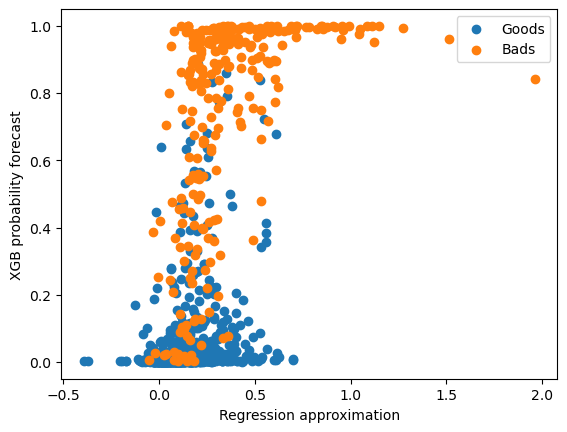

In [15]:
# Scatter plot of regression versus XGB outputs, colored by actual target
# Plot comparison
plt.scatter(df_comp.LR[df_comp.Y == 0], df_comp.XGB[df_comp.Y == 0], label="Goods")
plt.scatter(df_comp.LR[df_comp.Y == 1], df_comp.XGB[df_comp.Y == 1], label="Bads")
plt.xlabel("Regression approximation")
plt.ylabel("XGB probability forecast")
plt.legend(loc="best")
plt.savefig('reg_XGB.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Interpretation of the Plot:

The scatter plot shows the relationship between the regression approximation (from the linear regression surrogate model) and the XGBoost probability forecast for two classes: `Goods` (blue dots) and `Bads` (orange dots).

#### Key Observations:
1. **XGBoost Probability Forecast**: The vertical axis represents the probability predictions from the XGBoost model. These probabilities range from 0 to 1, where higher values indicate a higher likelihood of being classified as `BAD`.

2. **Regression Approximation**: The horizontal axis represents the predictions from the linear regression model, which approximates the XGBoost probability forecasts.

3. **Distribution of Goods (blue dots)**:
    - Most `Goods` are clustered around a lower probability forecast (near 0) from the XGBoost model.
    - The linear regression approximations for `Goods` also tend to be low (around 0).

4. **Distribution of Bads (orange dots)**:
    - Many `Bads` are clustered at a high probability forecast (near 1) from the XGBoost model.
    - The linear regression approximations for `Bads` are spread across a wider range but still show a tendency to be higher than those for `Goods`.

5. **Alignment of Points**:
    - There is a noticeable spread in the `Regression approximation` axis, suggesting that while the linear regression model captures some of the trends in the XGBoost predictions, there is still some discrepancy.

6. **Overlap of Goods and Bads**:
    - There is some overlap between `Goods` and `Bads` in the lower probability forecast range (0 to 0.4), indicating that both classes can share similar probability forecasts and approximations in this range.
    - `Bads` are more spread out in higher probability forecasts, indicating more variability in the linear regression model's approximation.

### Conclusion:
- The linear regression surrogate model captures the general trend of the XGBoost probability forecasts but with some variability.
- The XGBoost model seems effective in distinguishing between `Goods` and `Bads`, especially at the higher probability forecasts.
- The surrogate linear regression model provides an approximation that can help in understanding the feature contributions but may not be as precise as the XGBoost model in capturing the exact probability forecasts. 

This plot helps visualize how well the linear regression model approximates the XGBoost model's predictions and highlights the areas where the approximation might be less accurate.

## Permutation-based feature importance
We introduces the concepts of permutation-based feature importance in the lecture. Now we want to examine how it works in Python. Of course, this will require us finding a Python method that implements the approach. To shortcut your searching, note that there is such method in *the most popular Python library for ML* and it is called `permutation_importance`. 

In [16]:
# Permutation-based feature importance
from sklearn.inspection import permutation_importance
feature_imp = permutation_importance(estimator=model, X=X_test, y=y_test)


The calculation of feature importance is pretty easy. However, visualizing the estimates importance scores takes a little work. Fortunately, this is a standard task and ready-to-use demo code is easily found on the web. In fact, we only found to browse the [official sklearn website](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) and will find some nice demo code to plot feature importance scores as a boxplot.  

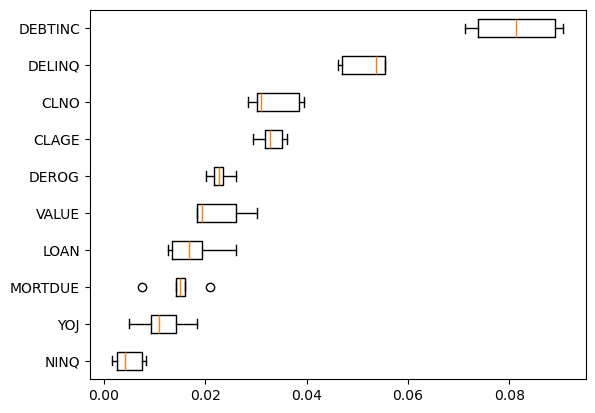

In [17]:
# Creating PDPs 
perm_sorted_idx = feature_imp.importances_mean.argsort()

plt.boxplot(
    feature_imp.importances[perm_sorted_idx].T, vert=False, labels=X.columns[perm_sorted_idx]
)
plt.savefig('feature_importance.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Interpretation of Permutation-Based Feature Importance Chart

The box plot shows the distribution of feature importance values for a set of features (DEBTINC, DELINQ, CLNO, CLAGE, VALUE, DEROG, MORTDUE, LOAN, YOJ, NINQ) across multiple permutations of the data. Each box represents the variability in importance scores, providing insights into which features are consistently important and which ones have more variable importance.

#### Key Elements of the Box Plot:
1. **Boxes**: Each box represents the interquartile range (IQR) of the feature importance values, i.e., the middle 50% of the data. The bottom and top edges of the box represent the 25th and 75th percentiles, respectively.
2. **Median Line**: The orange line inside each box represents the median (50th percentile) of the feature importance values.
3. **Whiskers**: The lines extending from the boxes (whiskers) represent the range of the data, excluding outliers. Typically, the whiskers extend to 1.5 times the IQR from the quartiles.
4. **Outliers**: Individual points beyond the whiskers represent outliers in the data.

### Interpretation of Each Feature:
- **DEBTINC**: The box plot shows a relatively narrow IQR with a high median, indicating that DEBTINC is consistently an important feature with one notable outlier.
- **DELINQ**: This feature has a relatively narrow IQR with a high median, indicating consistent importance with a few outliers.
- **CLNO**: The number of credit lines shows a moderate IQR, indicating variability in its importance across different permutations. The whiskers and a few outliers suggest a broader range of values.
- **CLAGE**: The age of the oldest credit line shows a moderate IQR, suggesting variability in its importance. Outliers are present.
- **VALUE**: The property value shows a moderate IQR with a few outliers, indicating variability in its importance.
- **DEROG**: This feature has a narrow IQR, indicating consistent importance with minimal outliers.
- **MORTDUE**: The amount due on the mortgage has a relatively narrow IQR, indicating consistent importance with minimal outliers.
- **LOAN**: The loan amount shows a narrow IQR, indicating consistent importance among most observations.
- **YOJ**: Years at the current job has a very narrow IQR, suggesting that its importance is consistent with few outliers.
- **NINQ**: The number of recent credit inquiries shows a narrow IQR, indicating consistent importance with some variability and outliers.

### Conclusion:
The box plot provides a clear visualization of the distribution and spread of each feature's importance in the dataset. Features like DEBTINC and DELINQ have consistently high importance with some variability, while features like LOAN and YOJ are more consistent with fewer outliers. Understanding these distributions helps in interpreting the importance and impact of each feature in predictive modeling.

### Key Takeaways:
- **Consistently Important**: DEBTINC, DELINQ, and CLNO show high median importance values, indicating they are crucial in the model's predictions.
- **Variable Importance**: Features like CLAGE and VALUE have more variability, suggesting their importance can change depending on the data permutation.
- **Less Important**: Features like YOJ, LOAN, and NINQ have lower median importance values, indicating they have less influence on the model's predictions.

This interpretation helps in understanding which features are consistently important and which ones have more variable importance, aiding in model interpretability and feature selection.

## Partial dependence
Next up, we discussed the concept of partial dependence. A partial dependence plot (PDP) complements feature importance analysis. For example, it is interesting to examine how those features that importance analysis identified as crucial affect model predictions (when averaging over the effect of the other features). Let's try to create a PDP for our XGB-classifier. 

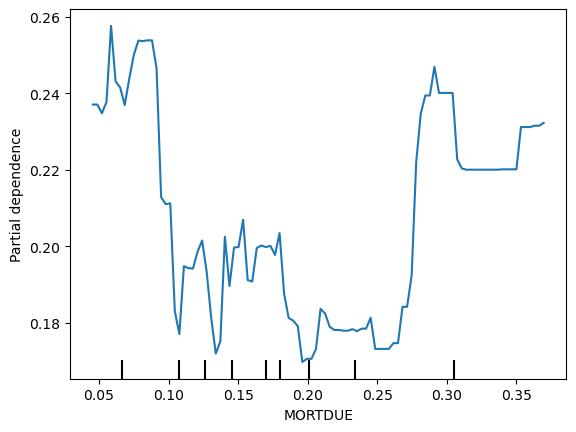

In [18]:
# Partial dependence analysis
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(estimator=model,X=X_test, features=['MORTDUE'])
plt.savefig('partial_dependence.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Interpretation of the Partial Dependence Plot:

The partial dependence plot (PDP) shows the marginal effect of the `MORTDUE` feature (the amount due on the mortgage) on the predicted outcome. This type of plot helps us understand how the model's predictions change when the `MORTDUE` feature varies, while all other features are held constant.

#### Key Elements of the PDP:
1. **X-Axis (MORTDUE)**: This represents the values of the `MORTDUE` feature. It ranges from approximately 0.05 to 0.35.
2. **Y-Axis (Partial Dependence)**: This shows the predicted outcome or probability, ranging from approximately 0.18 to 0.26.
3. **Ticks on X-Axis**: These indicate the distribution of the `MORTDUE` values in the dataset. The density of ticks gives a sense of how frequently different values of `MORTDUE` occur.

### Key Observations:
1. **Overall Trend**: The plot shows that the partial dependence of `MORTDUE` on the predicted outcome fluctuates significantly, indicating that `MORTDUE` has a complex relationship with the predicted probability.
2. **High Partial Dependence for Low `MORTDUE`**: When `MORTDUE` is low (around 0.05 to 0.10), the partial dependence is relatively high, close to 0.26. This suggests that lower amounts due on the mortgage are associated with higher predicted probabilities.
3. **Decrease in Partial Dependence**: As `MORTDUE` increases from around 0.10 to 0.20, the partial dependence drops significantly, reaching a low around 0.18. This indicates that medium values of `MORTDUE` are associated with lower predicted probabilities.
4. **Increase and Fluctuations**: Beyond 0.20, the partial dependence increases again but shows fluctuations. At around 0.25 to 0.30, there is an increase in the partial dependence to around 0.24, followed by a slight decrease and then stabilization.
5. **High Partial Dependence for High `MORTDUE`**: For higher values of `MORTDUE` (around 0.30 and above), the partial dependence stabilizes at around 0.23 to 0.24.

### Conclusion:
- **Complex Relationship**: The `MORTDUE` feature has a non-linear and complex relationship with the predicted outcome.
- **Impact at Different Ranges**: Low `MORTDUE` values are associated with higher predicted probabilities, while medium `MORTDUE` values have lower predicted probabilities. High `MORTDUE` values again show an increase in predicted probabilities, but with fluctuations.
- **Insightful Feature**: Understanding the partial dependence of `MORTDUE` can provide valuable insights into how changes in the amount due on the mortgage influence the model's predictions.

This PDP helps in interpreting the significance of the `MORTDUE` feature and its impact on the prediction, offering a deeper understanding of the model's behavior.